# PART 2: ANALYZING AND VISUALIZING DATA

In this notebook, I'll be using the 3 dataframes created previously to analyze 311 complaints in NYC in 2017. I'll explore the following:

1. Number of 10 most common complaint types per borough
2. Number of 10 most common complaint types per zip code (only the 10 most populous)
3. Complaint index for each borough (adjusted for population)

In [251]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

In [252]:
# Load DataFrames from Part 1
nyc2_df = pd.read_pickle('nyc2_df.pkl')
census_df = pd.read_pickle('census_df.pkl')
zips_df = pd.read_pickle('zips_df.pkl')

In [253]:
# Create list of 10 most common complaint types
complaints = nyc2_df['complaint_type'].value_counts().head(10).keys().tolist()
complaints

['Noise - Residential',
 'HEAT/HOT WATER',
 'Illegal Parking',
 'Blocked Driveway',
 'Street Condition',
 'UNSANITARY CONDITION',
 'Street Light Condition',
 'Noise - Street/Sidewalk',
 'Water System',
 'Noise']

In [254]:
# plot1_dict = {COMPLAINT1: [BOROUGH1_AMT, BOROUGH2_AMT, ...], COMPLAINT2: [...]}
plot1_dict = {}

# Get list of boroughs in alphabetical order from NYC zip code dataframe
boroughs = sorted(list(zips_df['borough'].unique()))

for complaint in complaints:
    perBorough = []
    for borough in boroughs:
        perBorough.append(len(nyc2_df[(nyc2_df['complaint_type'] == complaint) \
                                      & (nyc2_df['borough'] == borough)]))
    plot1_dict[complaint] = perBorough

In [255]:
pd.DataFrame.from_dict(plot1_dict, orient='index', columns=boroughs)

,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
Noise - Residential,57822,66629,51898,45397,6932
HEAT/HOT WATER,68430,65701,44381,29666,1980
Illegal Parking,16509,56260,19860,46242,7650
Blocked Driveway,25226,49680,3415,54762,3486
Street Condition,12198,26851,15482,32630,11422
UNSANITARY CONDITION,25347,27829,14758,11925,1942
Street Light Condition,17720,21533,10019,23963,6891
Noise - Street/Sidewalk,13849,20806,29630,7228,943
Water System,10034,18117,10518,18662,5522
Noise,3130,15750,30521,10893,1897


In [256]:
# Sanity check: The total amount of complaints across all boroughs should be no more
# than the total amount for the whole database since several records are missing
# borough/zip code data

for complaint in complaints:
    print(complaint)
    print(len(nyc2_df[(nyc2_df['complaint_type'] == complaint)]), '>=', 
          sum(plot1_dict[complaint]))

Noise - Residential
229314 >= 228678
HEAT/HOT WATER
210158 >= 210158
Illegal Parking
147525 >= 146521
Blocked Driveway
137547 >= 136569
Street Condition
98622 >= 98583
UNSANITARY CONDITION
81801 >= 81801
Street Light Condition
81537 >= 80126
Noise - Street/Sidewalk
72629 >= 72456
Water System
62853 >= 62853
Noise
62191 >= 62191


<IPython.core.display.Javascript object>


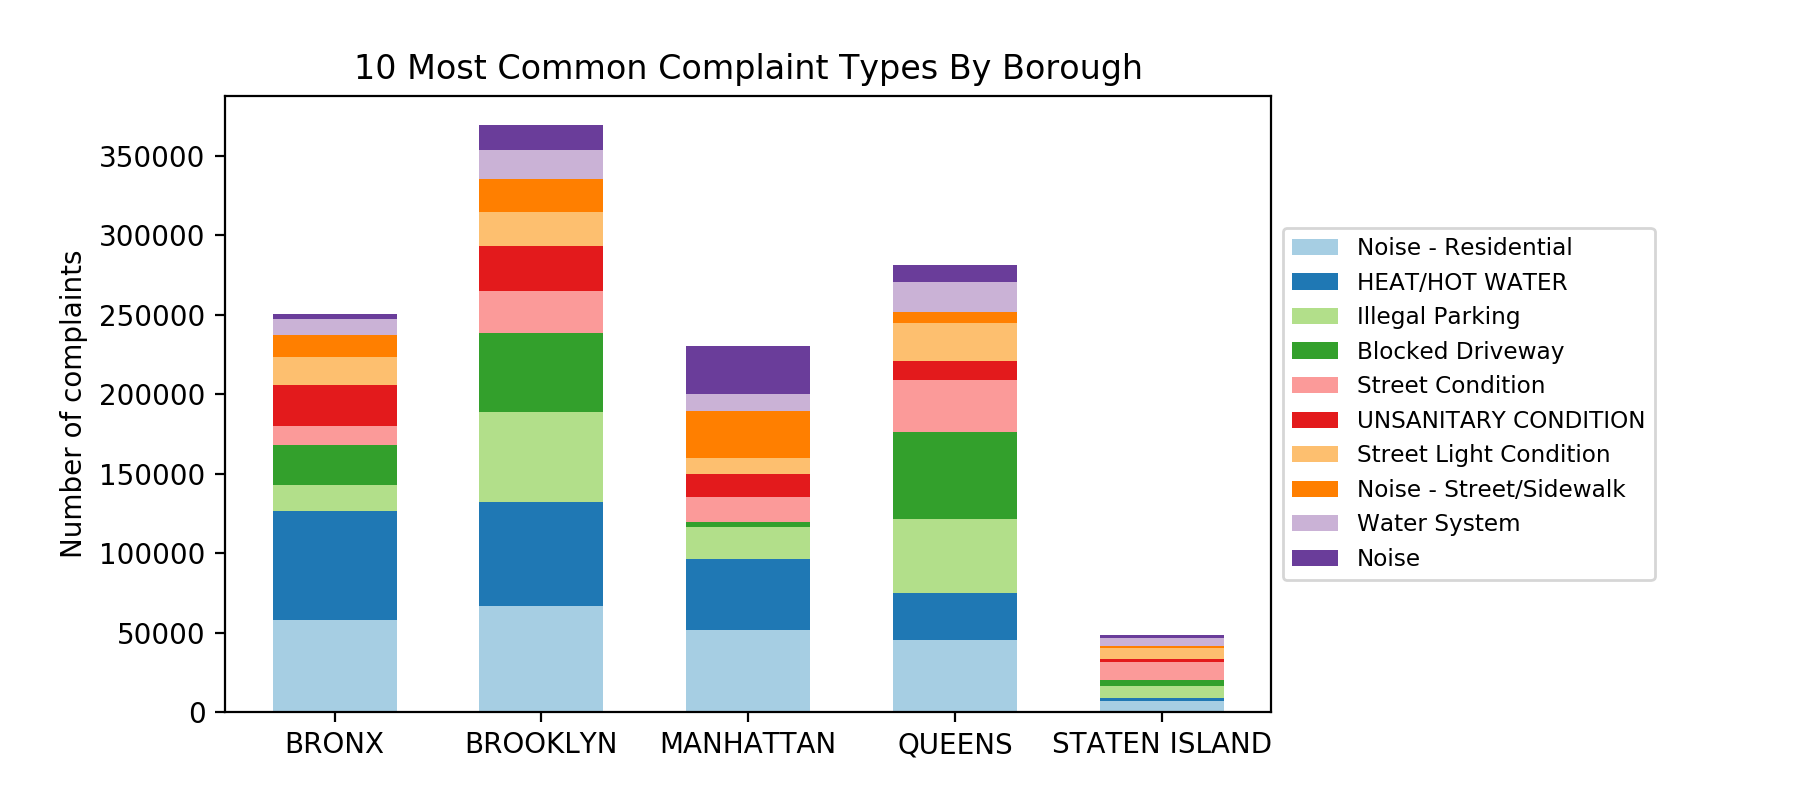

In [257]:
cmap = plt.get_cmap("Paired")

def stackedPlot(p_dict, areas, ax, width):
    ind = np.arange(len(areas)) 
    p = []
    p.append(ax.bar(ind, p_dict[complaints[0]], 
                     color=cmap(0), width=width))
    bottoms = [0]*len(areas)
    for idx in range(1, len(complaints)):
        bottoms = [sum(x) for x in \
                   zip(bottoms, p_dict[complaints[idx-1]])]
        p.append(ax.bar(ind, p_dict[complaints[idx]],
                         color=cmap(idx), width=width, bottom=bottoms))
    plt.ylabel('Number of complaints')
    plt.xticks(ind, areas)
                                    
        
width = 0.6
plt.figure(figsize=(9, 4))
ax = plt.subplot(111)

# Call Function
stackedPlot(plot1_dict, boroughs, ax, width)

plt.ylabel('Number of complaints')
plt.title('10 Most Common Complaint Types By Borough')

plt.legend(p, complaints, loc='center left', bbox_to_anchor=(1, 0.5),
           fontsize='small')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

plt.show()

In [258]:
def areaPlots(p_dict, areas, z, ax, width):
    ind = np.arange(len(complaints))
    p = []

    for idx in range(len(complaints)):
        p.append(ax.bar(ind[idx], p_dict[complaints[idx]][z], 
                        color=cmap(idx), width=width))

    plt.ylabel('Number of complaints')
    plt.title(areas[z])
    plt.xticks([],[])

<IPython.core.display.Javascript object>


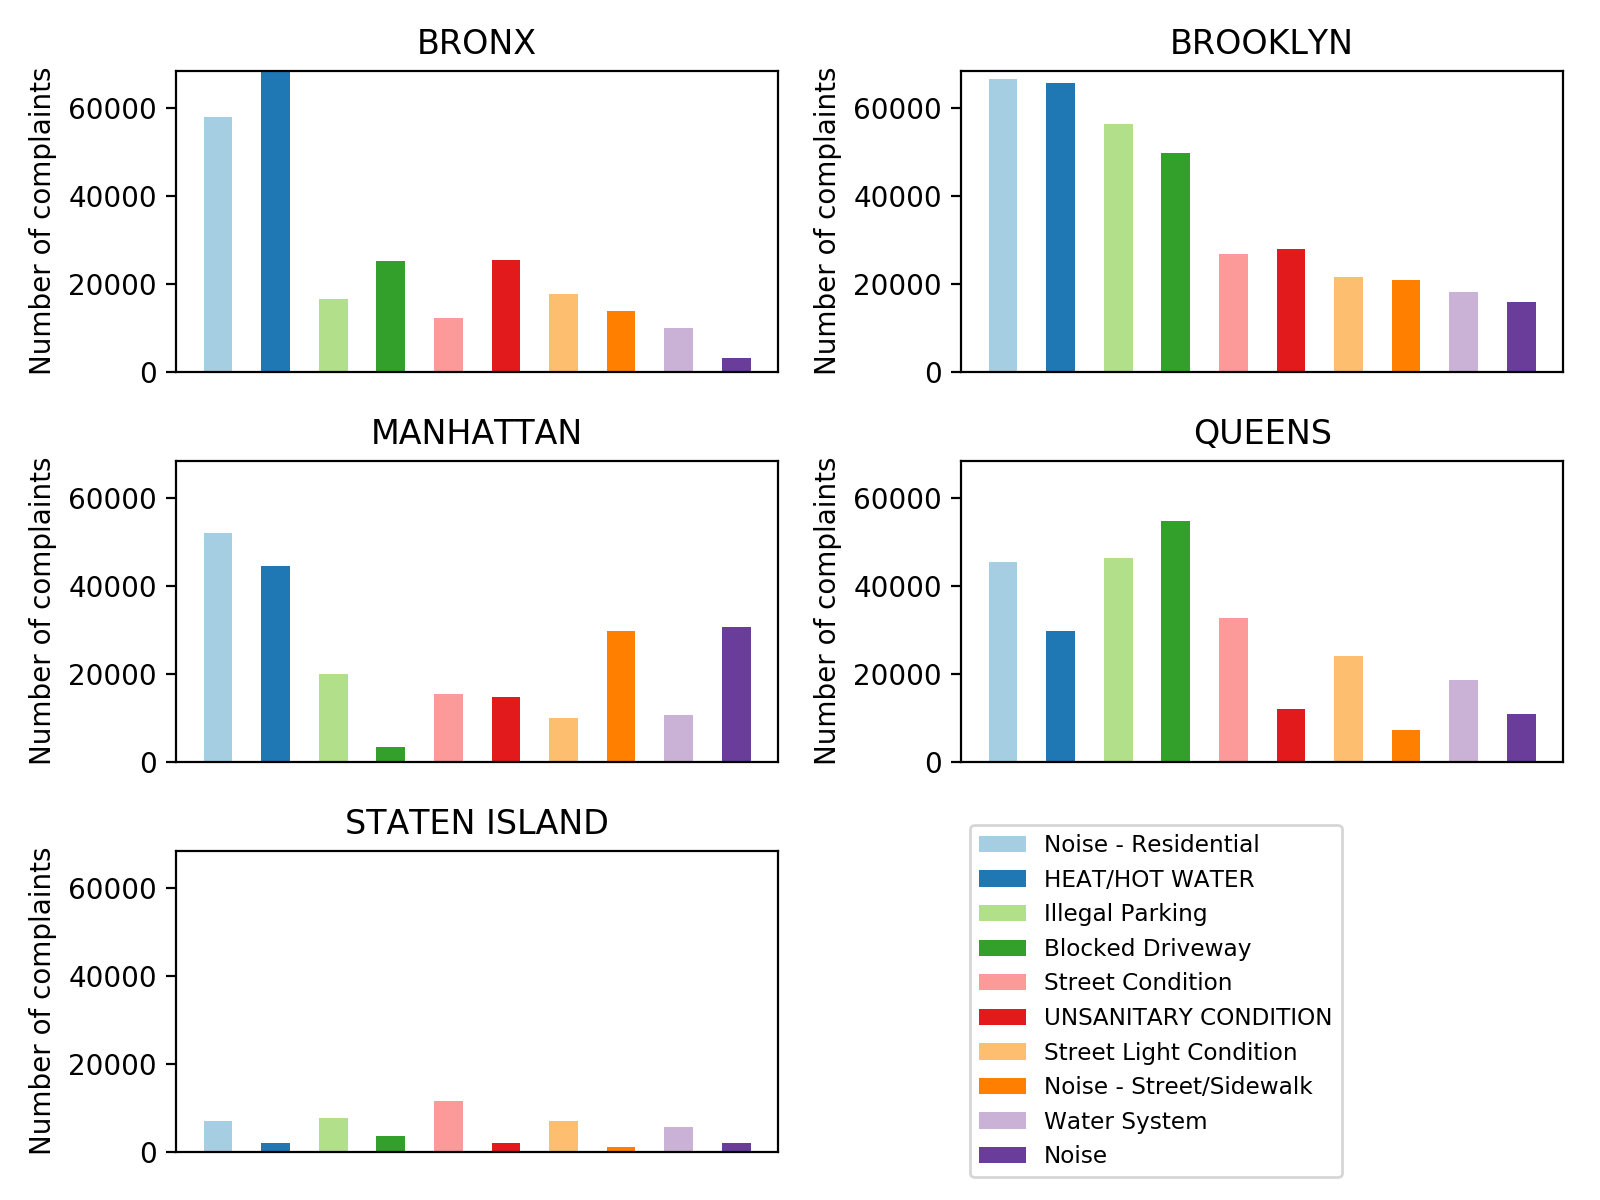

In [259]:
width = 0.5     

plt.figure(figsize=(8, 6))
for idx in range(len(boroughs)):
    ax = plt.subplot(321+idx)
    areaPlots(plot1_dict, boroughs, idx, ax, width)
    ax.set_ylim([0, max([max(v) for v in plot1_dict.values()])])

plt.tight_layout()
plt.legend(complaints, loc='center left', bbox_to_anchor=(1.3, 0.5),
           fontsize = 'small')


plt.show()

In [260]:
# Find the most populous zip codes
# Get list of zip codes from NYC zip code dataframe
zip_codes = list(zips_df['zip_code'].unique())
len(zip_codes)

240

In [261]:
# Find a match, if one exists, in the 2010 Census dataframe for each
# NYC zip code. If found, store the zip code and population as a tuple
# in new borough dictionary. e.g. 'MANHATTAN':[('10001', 21102), ...]

borough_dict = {b:[] for b in boroughs}
notInCensus = 0

for zc in zip_codes:
    p_df = census_df[census_df['Zip Code ZCTA'] == zc]
    if len(p_df) == 1:
        bkey = zips_df[zips_df['zip_code'] == zc].iloc[0]['borough']
        borough_dict[bkey].append((zc, p_df.iloc[0]['2010 Census Population']))
    elif len(p_df) == 0:
        #print(zc, len(p_df))
        notInCensus += 1
    else:
        print('Duplicate?', zc)
        
print('{} out of {} NYC zip codes did not have a matching record in the 2010 Census database.'
      .format(notInCensus, len(zip_codes)))

35 out of 240 NYC zip codes did not have a matching record in the 2010 Census database.


In [262]:
# Convoluted way to flatten dictionary lists of tuples into one list
biggest_zc = [bpair for blist in list(borough_dict.values()) for bpair in blist]
biggest_zc.sort(key=lambda x: x[1], reverse=True)
biggest_zc = [z[0] for z in biggest_zc[:10]]

In [263]:
# plot2_dict = {COMPLAINT1: [ZIP1_AMT, ZIP2_AMT, ...], COMPLAINT2: [...]}
plot2_dict = {}

for complaint in complaints:
    perZipCode = []
    for bzc in biggest_zc:
        perZipCode.append(len(nyc2_df[(nyc2_df['complaint_type'] == complaint) \
                                      & (nyc2_df['incident_zip'] == bzc)]))
    plot2_dict[complaint] = perZipCode

In [264]:
pd.DataFrame.from_dict(plot2_dict, orient='index', columns=biggest_zc)

,11368,11226,11373,11220,11385,10467,10025,11208,11236,11207
Noise - Residential,2342,4884,1901,1601,2456,5623,2076,2642,1728,3159
HEAT/HOT WATER,1523,7381,3964,1698,1661,6010,2213,1976,1078,2250
Illegal Parking,1226,1147,1313,2052,4282,969,764,2226,1494,1512
Blocked Driveway,4338,2147,2669,1695,3243,2158,116,2786,3008,2099
Street Condition,472,541,699,765,1368,577,631,879,1169,1287
UNSANITARY CONDITION,665,3369,605,796,675,2144,695,1393,586,1801
Street Light Condition,452,196,356,599,823,395,19,573,160,926
Noise - Street/Sidewalk,650,1812,278,493,557,658,1314,734,181,509
Water System,527,371,290,649,1236,561,514,759,633,765
Noise,165,481,287,392,493,280,1417,150,114,201


<IPython.core.display.Javascript object>


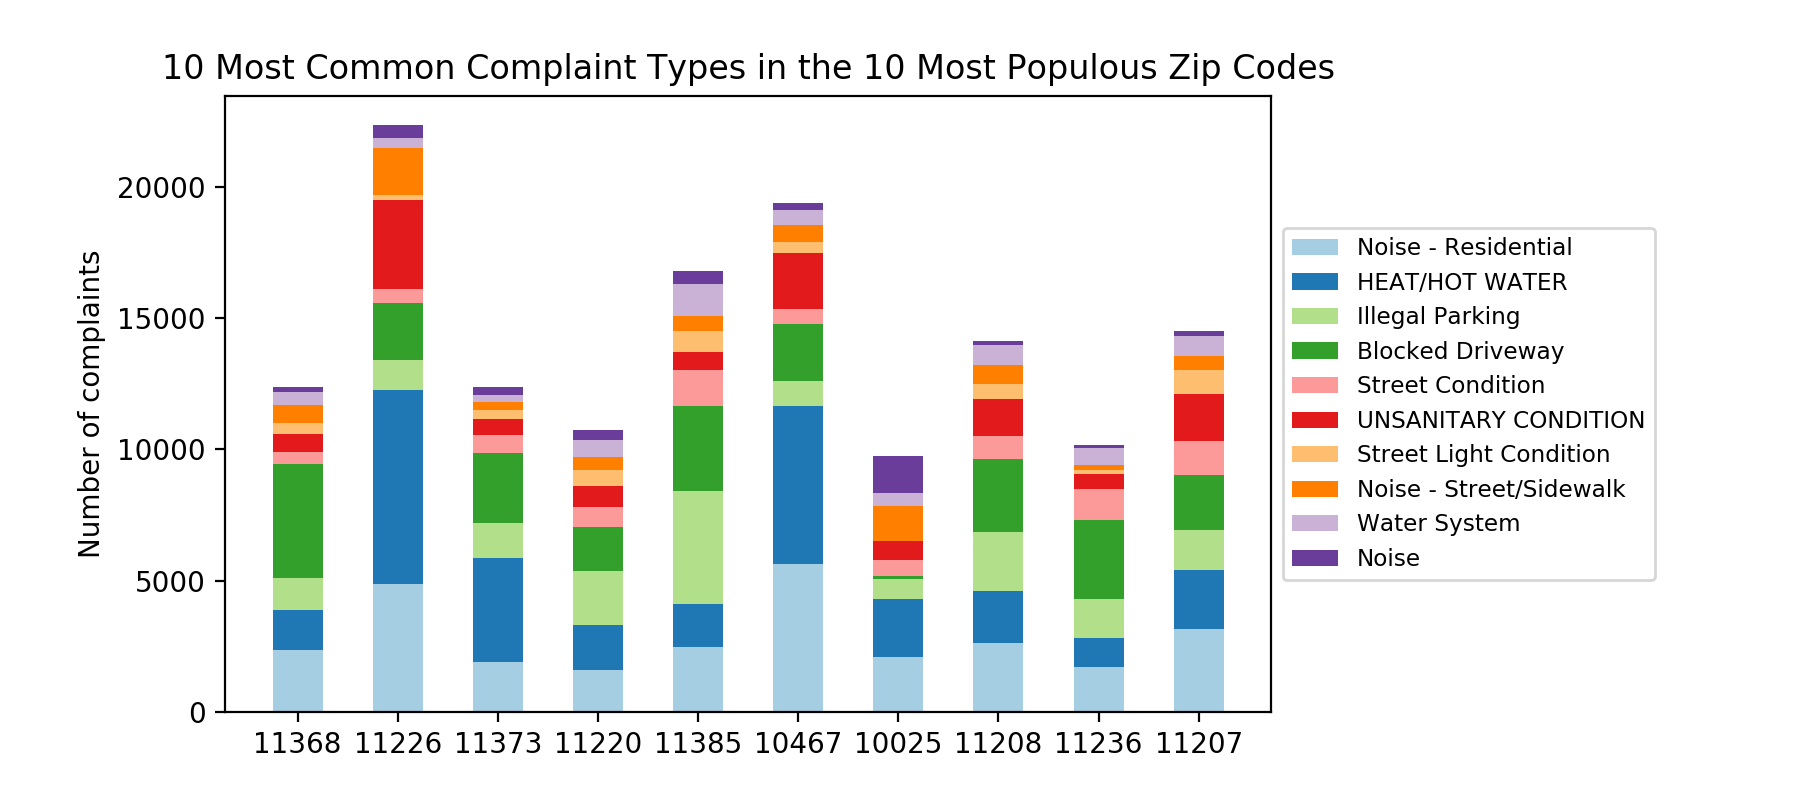

In [265]:
width = 0.5 
plt.figure(figsize=(9, 4))
ax = plt.subplot(111)

# Call function
stackedPlot(plot2_dict, biggest_zc, ax, width)

plt.title('10 Most Common Complaint Types in the 10 Most Populous Zip Codes')

plt.legend(p, complaints, loc='center left', bbox_to_anchor=(1, 0.5),
           fontsize='small')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

plt.show()

<IPython.core.display.Javascript object>


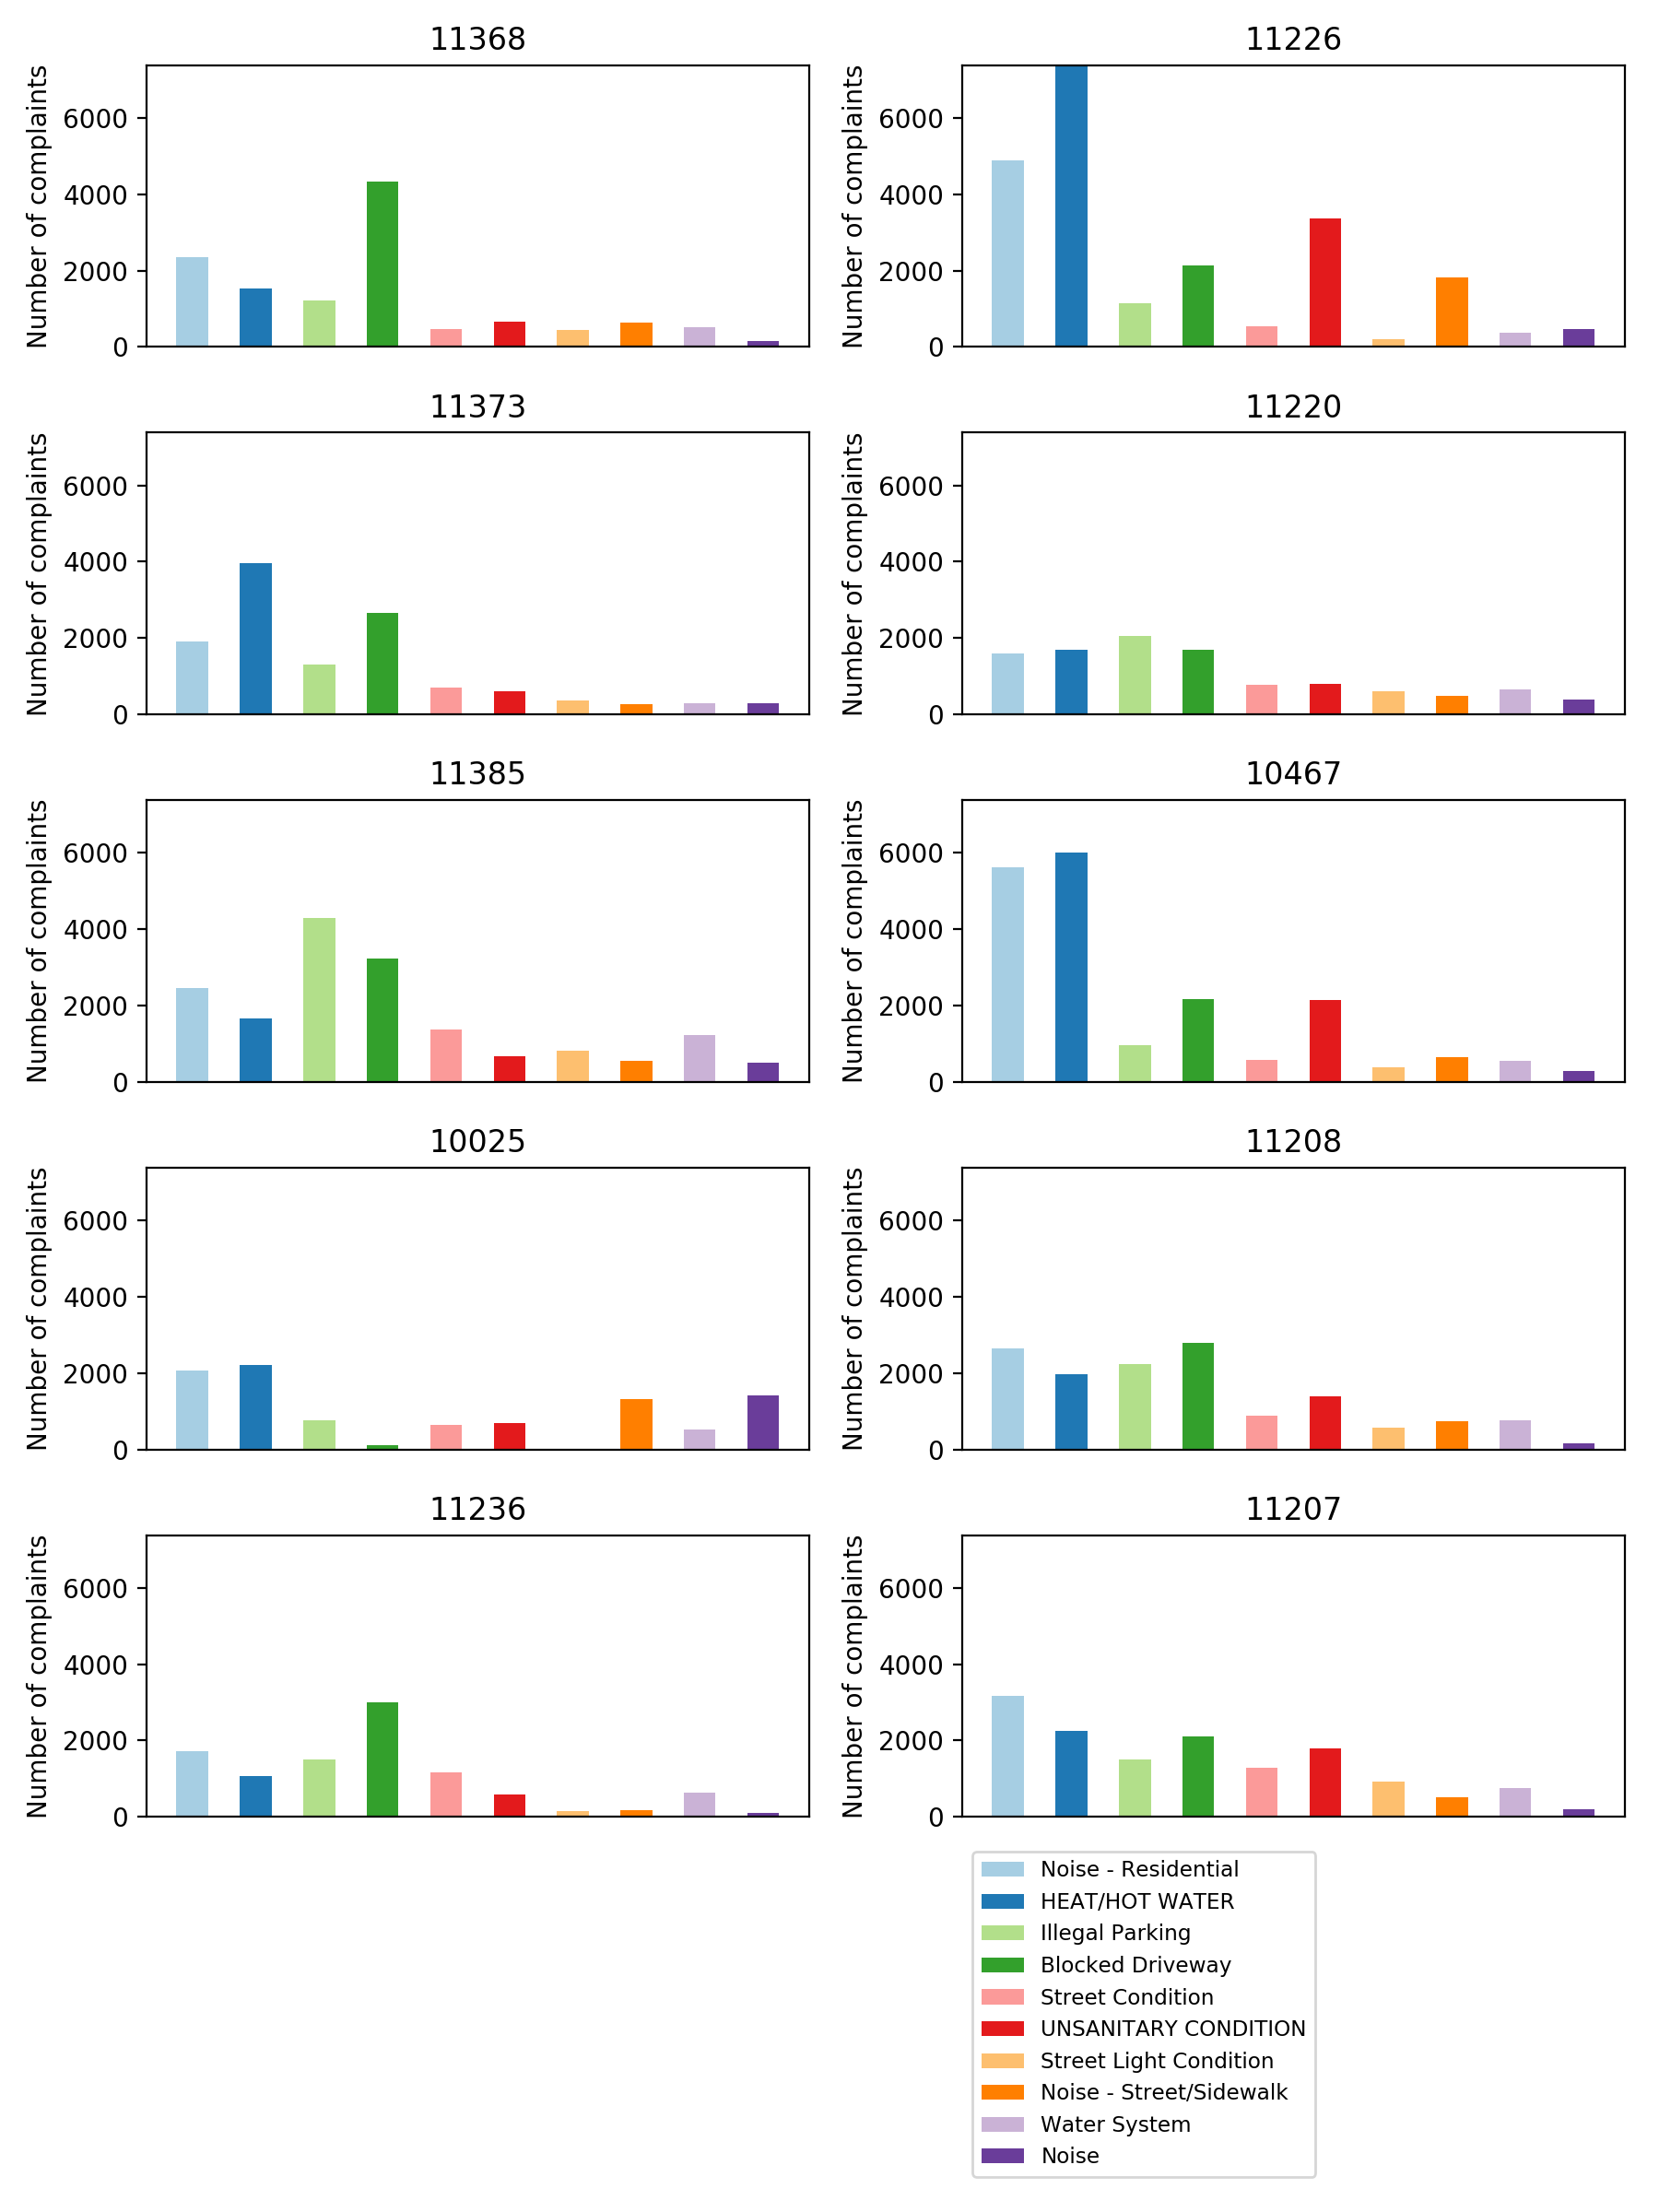

In [266]:
width = 0.5     

plt.figure(figsize=(9, 12))
for idx in range(len(biggest_zc)):
    ax = plt.subplot(6,2,1+idx)
    areaPlots(plot2_dict, biggest_zc, idx, ax, width)
    ax.set_ylim([0, max([max(v) for v in plot2_dict.values()])])

plt.tight_layout()
plt.legend(complaints, loc='center left', bbox_to_anchor=(0,-0.7),
           fontsize = 'small')


plt.show()

In [267]:
# Plot 3
# plot3_dict = {BOROUGH: [NUM_COMPLAINTS, POPULATION], ...}

plot3_dict = {}

for b in boroughs:
    # Get total number of complaints
    numComplaints = len(nyc2_df[nyc2_df['borough'] == b])
    borPop = sum([bd[1] for bd in borough_dict[b]])
    plot3_dict[b] = [numComplaints, borPop]
    
plot3_dict

{'BRONX': [455109, 1382480],
 'BROOKLYN': [768828, 2504700],
 'MANHATTAN': [481812, 1518994],
 'QUEENS': [593648, 2233454],
 'STATEN ISLAND': [129194, 468730]}

In [268]:
totalComplaints = len(nyc2_df)
totalPopulation = sum([p[1] for p in plot3_dict.values()])

plot3_dict['NYC TOTAL'] = [totalComplaints, totalPopulation]

# Calculate index by dividing complaints by population (i.e. complaints per person)
for region in plot3_dict.keys():
    plot3_dict[region].append(plot3_dict[region][0]/float(plot3_dict[region][1]))
    
# Normalize index by dividing by NYC TOTAL average index
for region in plot3_dict.keys():
    plot3_dict[region].append(plot3_dict[region][2]/float(plot3_dict['NYC TOTAL'][2]))

In [269]:
pd.DataFrame.from_dict(plot3_dict, orient='index', 
                       columns=['Complaints', 'Population', 'Complaint Index', 'Normalized'])

,Complaints,Population,Complaint Index,Normalized
BRONX,455109,1382480,0.329198,1.084529
BROOKLYN,768828,2504700,0.306954,1.011249
MANHATTAN,481812,1518994,0.317192,1.044976
QUEENS,593648,2233454,0.265798,0.875662
STATEN ISLAND,129194,468730,0.275626,0.908038
NYC TOTAL,2461208,8108358,0.303540,1.000000
